In [1]:
# =========================================================
# 0) Setup
# =========================================================
import pandas as pd
import numpy as np
import re, string, os, pickle, warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
DATA_PATH = r"D:\Projects\SMS_Classifier\SMSSpamCollection"
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)


In [2]:
# =========================================================
# 1) Load & Clean
# =========================================================
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'\d+', '', s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.strip()

df = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["label", "message"])
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df["clean_message"] = df["message"].apply(clean_text)

df.head()

,label,message,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [3]:
# =========================================================
# 2) Vectorize & Split (SAME split used in app)
# =========================================================
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X = tfidf.fit_transform(df["clean_message"])
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((4179, 5000),
 (1393, 5000),
 np.float64(0.13400335008375208),
 np.float64(0.1342426417803302))

In [4]:
# =========================================================
# 3) Model Zoo & Hyperparameter Grids
#    (Compact, strong baselines)
# =========================================================
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "LinearSVM": LinearSVC(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE)
}

param_grids = {
    "MultinomialNB": {
        "alpha": [0.1, 0.5, 1.0, 1.5]
    },
    "LogisticRegression": {
        "C": [0.1, 1, 3, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "max_iter": [2000]
    },
    "LinearSVM": {
        "C": [0.1, 1, 3, 10]
    },
    "RandomForest": {
        "n_estimators": [150, 250, 400],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    }
}


In [5]:
# =========================================================
# 4) Train & Hyper-tune (GridSearchCV)
# =========================================================
def fit_and_tune(name, model, grid, X_tr, y_tr, scoring="accuracy", cv=5):
    gs = GridSearchCV(model, grid, scoring=scoring, cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_tr, y_tr)
    return gs.best_estimator_, gs.best_params_, gs.best_score_

best_models = {}
best_params = {}
cv_scores = {}

for name, model in models.items():
    best_est, params, cv_score = fit_and_tune(name, model, param_grids[name], X_train, y_train)
    best_models[name] = best_est
    best_params[name] = params
    cv_scores[name] = cv_score

best_params, cv_scores

({'MultinomialNB': {'alpha': 0.5},
  'LogisticRegression': {'C': 10,
   'max_iter': 2000,
   'penalty': 'l2',
   'solver': 'lbfgs'},
  'LinearSVM': {'C': 1},
  'RandomForest': {'max_depth': None,
   'min_samples_split': 5,
   'n_estimators': 250}},
 {'MultinomialNB': np.float64(0.9784666074549466),
  'LogisticRegression': np.float64(0.9741589548176375),
  'LinearSVM': np.float64(0.9782265134802166),
  'RandomForest': np.float64(0.975594648024525)})

In [6]:
# =========================================================
# 5) Evaluation Helpers
# =========================================================
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        # fallback: hard labels (not ideal for ROC but won't crash)
        return model.predict(X)

def evaluate_model(name, model, X_te, y_te, show_cm=True):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    report = classification_report(y_te, y_pred, target_names=["ham", "spam"])
    print(f"==== {name} ====\nAccuracy: {acc:.4f}\n\n{report}")

    if show_cm:
        cm = confusion_matrix(y_te, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} — Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    return acc


==== MultinomialNB ====
Accuracy: 0.9756

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.97      0.84      0.90       187

    accuracy                           0.98      1393
   macro avg       0.97      0.92      0.94      1393
weighted avg       0.98      0.98      0.97      1393

==== LogisticRegression ====
Accuracy: 0.9813

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       1.00      0.86      0.93       187

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393

==== LinearSVM ====
Accuracy: 0.9856

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1206
        spam       0.99      0.90      0.94       187

    accuracy                           0.99      1393
 

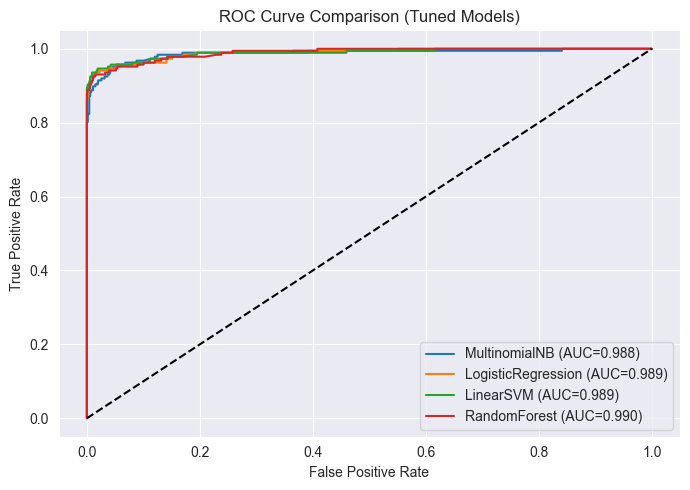

,model,test_accuracy
2,LinearSVM,0.985642
1,LogisticRegression,0.981335
3,RandomForest,0.979182
0,MultinomialNB,0.975592


In [7]:
# =========================================================
# 6) Evaluate All Tuned Models + ROC
# =========================================================
test_acc = {}
plt.figure(figsize=(7,5))
for name, model in best_models.items():
    # test metrics
    acc = evaluate_model(name, model, X_test, y_test, show_cm=False)
    test_acc[name] = acc

    # ROC
    scores = get_scores(model, X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Tuned Models)")
plt.legend()
plt.tight_layout()
plt.show()

pd.DataFrame({"model": list(test_acc.keys()), "test_accuracy": list(test_acc.values())}).sort_values("test_accuracy", ascending=False)


In [8]:
# =========================================================
# 7) Save Artifacts for the App (exactly what the app loads)
# =========================================================
with open(os.path.join(ARTIFACTS_DIR, "tfidf.pkl"), "wb") as f:
    pickle.dump(tfidf, f)

with open(os.path.join(ARTIFACTS_DIR, "X_test.pkl"), "wb") as f:
    pickle.dump(X_test, f)

with open(os.path.join(ARTIFACTS_DIR, "y_test.pkl"), "wb") as f:
    pickle.dump(y_test, f)

with open(os.path.join(ARTIFACTS_DIR, "best_models.pkl"), "wb") as f:
    pickle.dump(best_models, f)

with open(os.path.join(ARTIFACTS_DIR, "best_params.pkl"), "wb") as f:
    pickle.dump(best_params, f)

print("✅ Saved artifacts to ./artifacts")


✅ Saved artifacts to ./artifacts
